In [1]:
import numpy as np
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
from discretize import TreeMesh, TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
matplotlib.rcParams['font.size'] = 14
from pymatsolver import Pardiso
from matplotlib.colors import LogNorm

>> Use cython version


In [22]:
rx_locs = np.c_[np.linspace(-8000, 8000, 51), np.zeros(51)]
from discretize.utils import mkvc, refine_tree_xyz

In [97]:
dh = 200  # base cell width
dom_width_x = 34060  # domain width x
dom_width_z = 29830  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN")


mesh = refine_tree_xyz(
    mesh,
    rx_locs,
    octree_levels=[0, 0, 4, 4, 4],
    method="surface",
    finalize=False,
)

mesh = refine_tree_xyz(
    mesh, rx_locs, octree_levels=[4, 4], method="radial", finalize=False
)

# # Refine core mesh region
# xp, zp = np.meshgrid([-600.0, 600.0], [-400.0, 0.0])
# xyz = np.c_[mkvc(xp), mkvc(zp)]
# mesh = refine_tree_xyz(
#     mesh, xyz, octree_levels=[0, 0, 2, 8], method="box", finalize=False
# )

mesh.finalize()

(<matplotlib.collections.PolyCollection at 0x250335d3250>,)

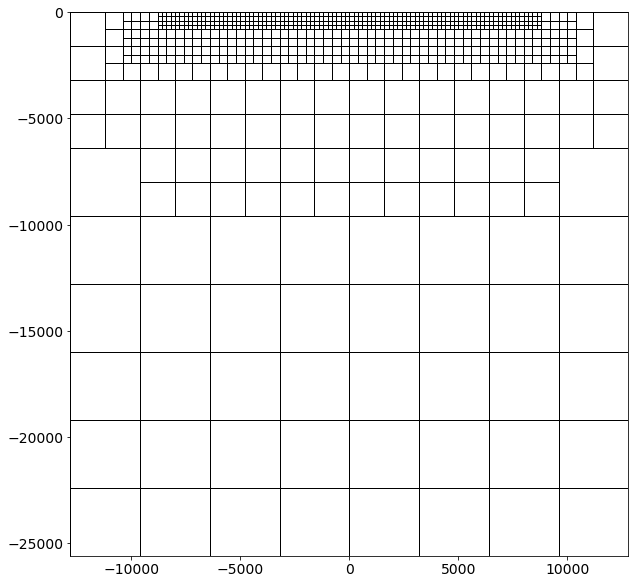

In [98]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
mesh.plot_image(
    np.ones(mesh.n_cells)*0., 
    pcolor_opts={'cmap':'binary', 'vmin':0, 'vmax':1}, 
    grid=True, 
    grid_opts={'color':'k'},
    ax=ax
)

In [99]:
sigma_back = 1e-1
sigma_right = 1e-3
sigma_air = 1e-8

cells = mesh.cell_centers
sigma = np.ones(mesh.n_cells) * sigma_back
sigma[cells[:, 0] >= 0] = sigma_right
sigma[cells[:, -1] >= 0] = sigma_air
frequencies = np.logspace(-2, 1, 3)

In [100]:
# fig, ax = plt.subplots(1,1, figsize=(10, 10))
# mesh.plot_image(sigma, grid=True, ax=ax, pcolor_opts={'norm':LogNorm(), 'cmap':'turbo'})
# ax.plot(rx_locs[:,0], rx_locs[:,1], '.')
# ax.set_aspect(1)

## Extract core mesh

In [101]:
xmin = mesh_tensor.x0[0] + mesh_tensor.hx[:npad].sum()
xmax = mesh_tensor.x0[0] +  mesh_tensor.hx[:npad+ncx].sum()
zmin = mesh_tensor.x0[1] + mesh_tensor.hy[:npad].sum()
zmax = mesh_tensor.x0[1] +  mesh_tensor.hy[:npad+ncz].sum()

In [102]:
from discretize import utils as dis_utils
xylim=np.array([[xmin, xmax],[zmin, zmax]])
inds_core, mesh_core = dis_utils.extract_core_mesh(xylim, mesh_tensor)

In [103]:
xylim

array([[-10800.,  10800.],
       [-21600.,      0.]])

In [104]:
P_tree_to_tensor = dis_utils.volume_average(mesh, mesh_core)

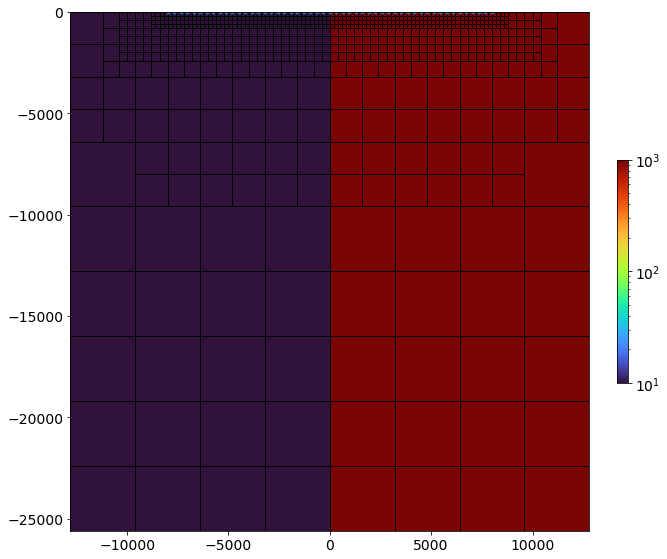

In [105]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_image(1./sigma, grid=True, ax=ax, pcolor_opts={'norm':LogNorm(vmin=10, vmax=1000), 'cmap':'turbo'})
plt.colorbar(out[0], fraction=0.02)
ax.plot(rx_locs[:,0], rx_locs[:,1], '.')
ax.set_aspect(1)

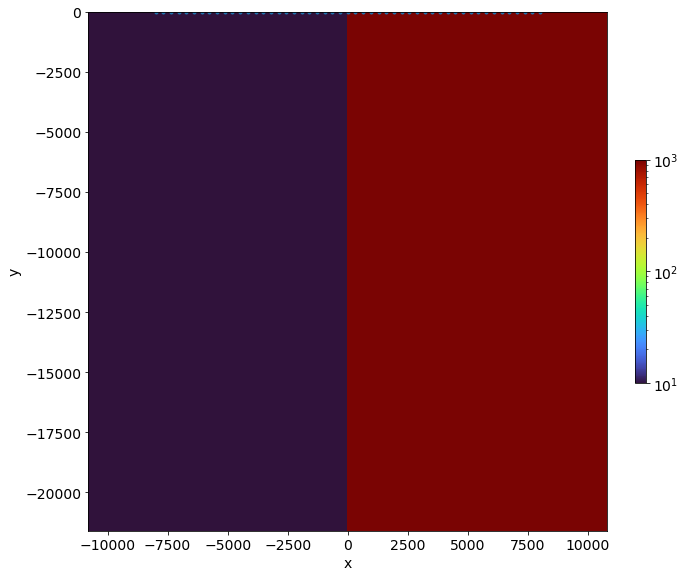

In [106]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh_core.plot_image(1./(P_tree_to_tensor*sigma), grid=False, ax=ax, pcolor_opts={'norm':LogNorm(vmin=10, vmax=1000), 'cmap':'turbo'})
plt.colorbar(out[0], fraction=0.02)
ax.plot(rx_locs[:,0], rx_locs[:,1], '.')
ax.set_aspect(1)

In [107]:
# simulation class for TE mode
rx_list_te = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="phase"
    ),
]
src_list_te = [nsem.sources.Planewave(rx_list_te, frequency=f) for f in frequencies]
survey_te = nsem.Survey(src_list_te)

ind_active = sigma != sigma_air
act_map = maps.InjectActiveCells(mesh, ind_active, np.log(1e-8))
exp_map = maps.ExpMap(mesh=mesh)
sigma_map = exp_map * act_map
sim_te= nsem.simulation.Simulation2DElectricField(
    mesh,
    survey=survey_te,
    sigmaMap=sigma_map,
    solver=Pardiso,
)

In [108]:
# simulation class for TM mode
rx_list_tm = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="phase"
    ),
]
src_list_tm = [nsem.sources.Planewave(rx_list_tm, frequency=f) for f in frequencies]
survey_tm = nsem.Survey(src_list_tm)

sim_tm = nsem.simulation.Simulation2DMagneticField(
    mesh,
    survey=survey_tm,
    sigmaMap=sigma_map,
    solver=Pardiso,
)

In [109]:
n_rx_loc = rx_locs.shape[0]
n_freq = len(frequencies)

In [110]:
m = np.log(sigma[ind_active])

In [111]:
pred_te = sim_te.dpred(m)
pred_tm = sim_tm.dpred(m)
PRED_te = pred_te.reshape((n_freq, 2, n_rx_loc))
PRED_tm = pred_tm.reshape((n_freq, 2, n_rx_loc))

rho_app_te = PRED_te[:,0,:]
rho_app_tm = PRED_tm[:,0,:]

phase_te = PRED_te[:,1,:]
phase_tm = PRED_tm[:,1,:]

In [112]:
rerr_rho_app = 0.05
floor_phase = 2
std_te = np.zeros_like(PRED_te)
std_te[:,0,:] = abs(rho_app_te) * rerr_rho_app
std_te[:,1,:] = np.ones_like(phase_te) * floor_phase
std_te = std_te.flatten()

std_tm = np.zeros_like(PRED_tm)
std_tm[:,0,:] = abs(rho_app_tm) * rerr_rho_app
std_tm[:,1,:] = np.ones_like(phase_tm) * floor_phase
std_tm = std_tm.flatten()

In [113]:
nrx, nfreq = phase_te.shape

In [114]:
noise_te = np.zeros_like(PRED_te)
noise_te[:,0,:] = abs(rho_app_te) * rerr_rho_app * np.random.randn(nrx, nfreq)
noise_te[:,1,:] = np.ones_like(phase_te) * floor_phase * np.random.randn(nrx, nfreq)
noise_te = noise_te.flatten()

noise_tm = np.zeros_like(PRED_tm)
noise_tm[:,0,:] = abs(rho_app_tm) * rerr_rho_app * np.random.randn(nrx, nfreq)
noise_tm[:,1,:] = np.ones_like(phase_tm) * floor_phase * np.random.randn(nrx, nfreq)
noise_tm = noise_tm.flatten()

In [115]:
dobs_te = pred_te + noise_te
dobs_tm = pred_tm + noise_tm

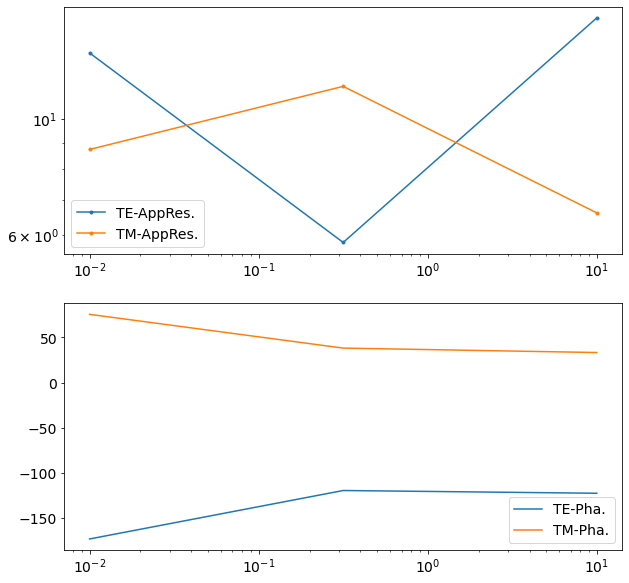

In [116]:
i_sounding = 21
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
ax1, ax2 = axs
ax1.loglog(frequencies, rho_app_te[:,i_sounding], '.-', label='TE-AppRes.')
ax1.loglog(frequencies, rho_app_tm[:,i_sounding], '.-', label='TM-AppRes.')
ax1.legend()

ax2.semilogx(frequencies, phase_te[:,i_sounding], label='TE-Pha.')
ax2.semilogx(frequencies, phase_tm[:,i_sounding], label='TM-Pha.')
ax2.legend()

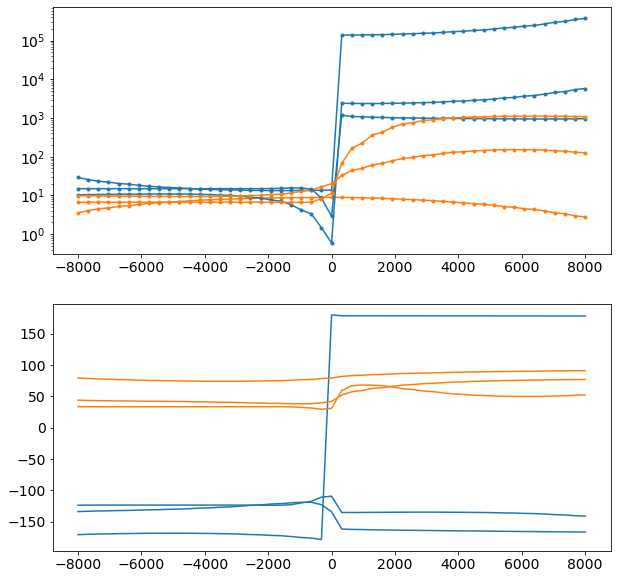

In [117]:
i_freq = -1
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for i_freq in range(len(frequencies)):
    ax1, ax2 = axs
    ax1.semilogy(rx_locs[:,0], rho_app_te[i_freq,:], '.-', label='TE-AppRes.', color='C0')
    ax1.semilogy(rx_locs[:,0], rho_app_tm[i_freq,:], '.-', label='TM-AppRes.', color='C1')
#     ax1.legend()

    ax2.plot(rx_locs[:,0], phase_te[i_freq,:], label='TE-Pha.', color='C0')
    ax2.plot(rx_locs[:,0], phase_tm[i_freq,:], label='TM-Pha.', color='C1')
#     ax2.legend()

### Issues?

There seems an issue on the boundary condition for the octree code?

(<matplotlib.collections.PolyCollection at 0x25033688550>,)

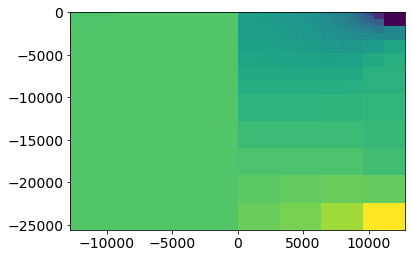

In [118]:
f_te = sim_te.fields(m)
mesh.plot_image(f_te[src_list_te[0], 'e'].real, v_type='Ex')

In [69]:
sigma_map * m

array([1.e-01, 1.e-01, 1.e-01, ..., 1.e-08, 1.e-08, 1.e-08])

In [70]:
te_data_object = data.Data(survey_te, dobs=dobs_te, standard_deviation=std_te) 
tm_data_object = data.Data(survey_tm, dobs=dobs_tm, standard_deviation=std_tm) 

In [71]:
dmis_te = data_misfit.L2DataMisfit(data=te_data_object, simulation=sim_te)
dmis_tm = data_misfit.L2DataMisfit(data=tm_data_object, simulation=sim_tm)

In [47]:
m0 = np.ones(ind_active.sum()) * np.log(1./20.)

In [48]:
dmis = dmis_te + dmis_tm

# Define the regularization (model objective function)
reg = regularization.Simple(
    mesh,
    indActive=ind_active,
    mref=m0,
    alpha_s=1e-5,
    alpha_x=1,
    alpha_y=1,
)

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=40, maxIterCG=30)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# Define MT Inversion Directives
# ------------------------------
#
# Here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

directives_list = [
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
]

#####################################################################
# Running the MT Inversion
# ------------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
mt_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = mt_inversion.run(m0)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solver_opts as the Simulation2DElectricField problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.70e+00  8.19e+05  0.00e+00  8.19e+05    9.34e+05      0              
   1  8.50e-01  4.31e+05  2.11e+03  4.33e+05    1.32e+05      0              
   2  4.25e-01  3.67e+05  1.49e+04  3.73e+05    2.31e+04      0   Skip BFGS  
   3  2.12e-01  3.58e+05  2.64e+04  3.63e+05    3.79e+05      0   Skip BFGS  
------------------------------------------------------------------
0 :    ft     = 3.6488e+05 <= alp*descent     = 3.6349e+05
1 : maxIterLS =      10    <= iterLS          =     10
------------------------- End Linesearch -------------------

In [28]:
pred_te = sim_te.dpred(recovered_conductivity_model)
pred_tm = sim_tm.dpred(recovered_conductivity_model)
PRED_te = pred_te.reshape((n_freq, 2, n_rx_loc))
PRED_tm = pred_tm.reshape((n_freq, 2, n_rx_loc))

rho_app_te_pred = PRED_te[:,0,:]
rho_app_tm_pred = PRED_tm[:,0,:]

phase_te_pred = PRED_te[:,1,:]
phase_tm_pred = PRED_tm[:,1,:]

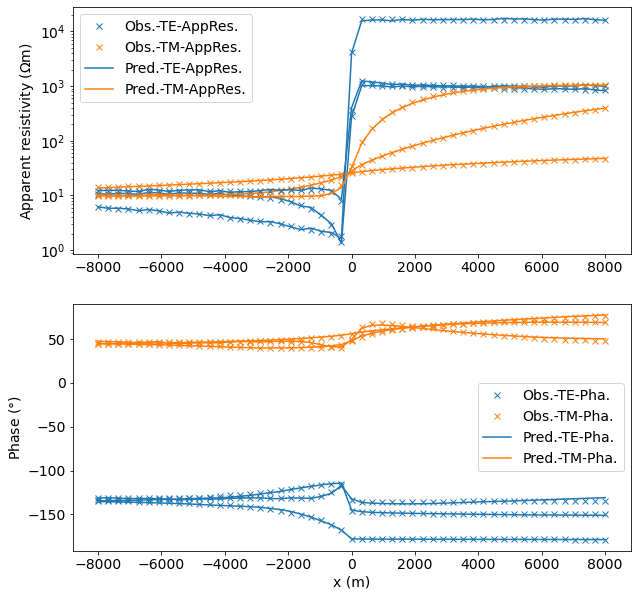

In [51]:
i_freq = -1
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for i_freq in range(len(frequencies)):
    ax1, ax2 = axs
    if i_freq == 0:
        ax1.semilogy(rx_locs[:,0], rho_app_te[i_freq,:], 'x', label='Obs.-TE-AppRes.', color='C0')
        ax1.semilogy(rx_locs[:,0], rho_app_tm[i_freq,:], 'x', label='Obs.-TM-AppRes.', color='C1')
        ax1.semilogy(rx_locs[:,0], rho_app_te_pred[i_freq,:], label='Pred.-TE-AppRes.', color='C0')
        ax1.semilogy(rx_locs[:,0], rho_app_tm_pred[i_freq,:], label='Pred.-TM-AppRes.', color='C1')

        ax2.plot(rx_locs[:,0], phase_te[i_freq,:], 'x', label='Obs.-TE-Pha.', color='C0')
        ax2.plot(rx_locs[:,0], phase_tm[i_freq,:], 'x', label='Obs.-TM-Pha.', color='C1')
        ax2.plot(rx_locs[:,0], phase_te_pred[i_freq,:], label='Pred.-TE-Pha.', color='C0')
        ax2.plot(rx_locs[:,0], phase_tm_pred[i_freq,:], label='Pred.-TM-Pha.', color='C1')
        
    else:
        ax1.semilogy(rx_locs[:,0], rho_app_te[i_freq,:], 'x', color='C0')
        ax1.semilogy(rx_locs[:,0], rho_app_tm[i_freq,:], 'x', color='C1')
        ax1.semilogy(rx_locs[:,0], rho_app_te_pred[i_freq,:], color='C0')
        ax1.semilogy(rx_locs[:,0], rho_app_tm_pred[i_freq,:], color='C1')

        ax2.plot(rx_locs[:,0], phase_te[i_freq,:], 'x', color='C0')
        ax2.plot(rx_locs[:,0], phase_tm[i_freq,:], 'x', color='C1')
        ax2.plot(rx_locs[:,0], phase_te_pred[i_freq,:], color='C0')
        ax2.plot(rx_locs[:,0], phase_tm_pred[i_freq,:], color='C1')
        
    #     ax1.legend()
ax2.set_xlabel("x (m)")
ax1.set_ylabel("Apparent resistivity ($\Omega$m)")
ax2.set_ylabel("Phase ($\degree$)")
ax1.legend()
ax2.legend()

In [30]:
sigma_est = sigma_map*recovered_conductivity_model

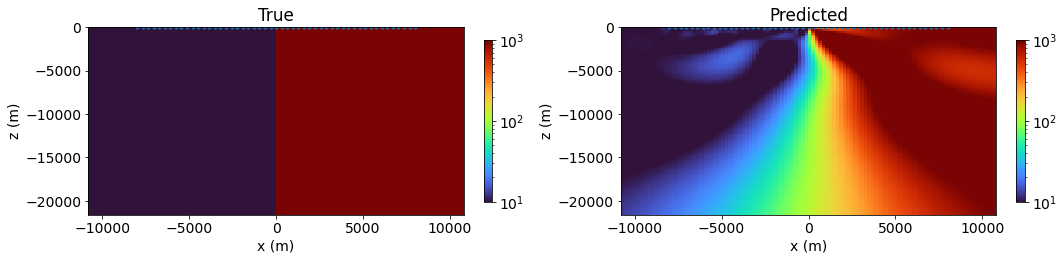

In [44]:
matplotlib.rcParams['font.size'] = 14
fig, axs = plt.subplots(1,2, figsize=(15, 7.5))
ax1, ax2 = axs
out = mesh_core.plot_image(1./sigma[inds_core], grid=False, ax=ax1, pcolor_opts={'norm':LogNorm(vmin=10, vmax=1000), 'cmap':'turbo'})
plt.colorbar(out[0], fraction=0.02, ax=ax1)
ax1.plot(rx_locs[:,0], rx_locs[:,1], '.')
ax1.set_aspect(0.5)

out = mesh_core.plot_image(1./sigma_est[inds_core], grid=False, ax=ax2, pcolor_opts={'norm':LogNorm(vmin=10, vmax=1000), 'cmap':'turbo'})
plt.colorbar(out[0], fraction=0.02, ax=ax2)
ax2.plot(rx_locs[:,0], rx_locs[:,1], '.')
ax2.set_aspect(0.5)
plt.tight_layout()
titles = ["True","Predicted"]
for ii, ax in enumerate(axs):
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_title(titles[ii])

## thoughts - worthwhile to store J (?)